In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import time
import seaborn as sb
from pylab import rcParams

# Define Functions

Make sure all antibiotic starting points are in the carrier (value 0) rather than reservoir shell (value 1)

In [20]:
def in_carrier(Ab,R,Size,ST):
    x = Ab[:,0]
    y = Ab[:,1]
    z = Ab[:,2]
    elute = Ab[:,4]
    for i in range(len(Ab)):
        while R[x[i],y[i],z[i]] != 0: 
            x[i],y[i] = np.random.randint(0,Size+2*ST,size = 2) # set new starting point until it is in the carrier
            z[i] = np.random.randint(0,Size+2)
    Ab[:,0] = x
    Ab[:,1] = y
    Ab[:,2] = z
    
    return Ab

When antibiotics move one step, make sure they move into carrier (value 0 or 3) rather than reservoir shell (value 1).  Label any eluted antibiotics (moved into exit (value of 3)) by replacing 0 (not eluted) with 1 (eluted) in final column (column 4) of antibiotic array. If antibiotic moved, cumulative number of steps (column 3 in antibiotic array) increases by one.

In [21]:
def move_once(Ab,Reservoir):
    # boolean mask to target non-eluted antibiotics
    b = Ab[:,4] == 0  
    b = b[:,np.newaxis]
    
    # pick random direction for antibiotic to move
    move_direction = np.random.randint(-1,2,size = [len(Ab),3]) 
    move = b*move_direction + Ab[:,0:3] # determine where the new location would be
    x = move[:,0]
    y = move[:,1]
    z = move[:,2]
    Material = Reservoir[x,y,z] # identify what is the material type of the location of the move
    
    # create Boolean masks to isolate antibiotics in different materials
    b_carrier = Material == 0
    b_exit = Material == 3
    b_carrier = b_carrier[:,np.newaxis]
    b_exit = b_exit[:,np.newaxis]
    
    # Update all antibiotics except ones that are already eluted or would move into reservoir material (value 1)
    Ab[:,0:3] += b*b_carrier*move_direction # non-eluted antibiotics move to carrier
    Ab[:,4:5] += 1*b_exit*b # update eluted column for antibiotics that eluted 
    
    # Update cumulative number of steps for non-eluted antibiotics
    Ab[:,3:4] += 1*b

    return Ab
        

Shift all exits (value 3) inward one time by replacing adjacent carrier (value 0) to simulate erosion 

In [22]:
def Surf_degrade(Reservoir):
    
    # determine difference between adjacent values in Reservoir array
    x = np.diff(Reservoir,axis=0)
    y = np.diff(Reservoir,axis=1)
    z = np.diff(Reservoir,axis=2)
    
    # determine indeces in Reservoir array where there is a carrier (value 0) next to an exit (value 3)
    # which has a difference of abs(3).  Since len(diff matrix) decreases by one, values of -3 need
    # to be shifted by one (but not for +3)
    i_x_pos = np.asarray(np.where(x==3))
    i_y_pos = np.asarray(np.where(y==3))
    i_z_pos = np.asarray(np.where(z==3))
    i_x_neg = np.asarray(np.where(x==-3))
    i_y_neg = np.asarray(np.where(y==-3))
    i_z_neg = np.asarray(np.where(z==-3))
    i_x_neg[0,:] += 1
    i_y_neg[1,:] += 1
    i_z_neg[2,:] += 1
    
    # Convert all carrier values adjacent to exit values into exit values themselves
    Reservoir[i_x_pos[0,:],i_x_pos[1,:],i_x_pos[2,:]] = 3
    Reservoir[i_y_pos[0,:],i_y_pos[1,:],i_y_pos[2,:]] = 3
    Reservoir[i_z_pos[0,:],i_z_pos[1,:],i_z_pos[2,:]] = 3
    Reservoir[i_x_neg[0,:],i_x_neg[1,:],i_x_neg[2,:]] = 3
    Reservoir[i_y_neg[0,:],i_y_neg[1,:],i_y_neg[2,:]] = 3
    Reservoir[i_z_neg[0,:],i_z_neg[1,:],i_z_neg[2,:]] = 3
        
    return Reservoir
    
    
    

Reservoir Animation to confirm shape

In [23]:
def animate(i):
    Reservoir_slice = Reservoir[:,:,i]
    colors = plt.get_cmap('hot',4)
    p = plt.pcolormesh(Reservoir_slice, cmap=colors, vmin=0, vmax=3)

# uncomment the code below to animate the current Reservoir array

#fig = plt.figure(figsize=(6,6))
#plt.title('Animation - Aerial View of Reservoir')
#ani = animation.FuncAnimation(fig, animate, frames=Size+2, repeat=True)

Initialize reservoir

In [24]:
def init_Reservoir(Size,d,L,ST,s):
    X = ST+(Size-d)//2
    Z = 1+(Size-d)//2
    E = Size+2*ST
    
    # initialize Reservoir with carrier values (0)
    R = np.zeros([E,E,Size+2])

    # edges of Reservoir are converted into Reservoir shell (value 1)
    R[:,:,0] = 1
    R[:,:,-1] = 1
    R[0:ST,:,:] = 1
    R[0,X:X+d,Z:Z+d] = 3

    # Create shell surrounding channel
    R[1:L,X-s:X+d+s,Z-s:Z+d+s] = 1

    # Hollow out shell to create channel
    R[1:L,X:X+d,Z:Z+d] = 0

    # Flip to make channel on opposite side and concatenate into same array
    R2 = np.flip(R)
    R_trash,R2_split = np.split(R2,2,axis=0)
    R1_split,R_trash = np.split(R,2,axis=0)
    R12 = np.concatenate((R1_split,R2_split))

    # Transpose to make other two channels
    R34 = np.transpose(R12,axes=(1,0,2))

    # Combine into an array with all four channels
    Reservoir = R12 + R34
    Reservoir = np.where(Reservoir==2,1,Reservoir)
    
    return Reservoir

Experimental data to determine model fit

In [25]:
def experimental_data(d):

    Time_points = [0, 1, 3, 5, 7, 9, 11, 13, 17, 21, 25, 30, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133]

    D10 = [0, 0.060795138, 0.096584449, 0.133186293, 0.241388423, 0.391103488, 0.527989929, 0.626451674, 0.837716864, 0.944730148, 0.976973656, 0.989835003, 0.995497585, 0.998507229, 1]
   
    D20 = [0, 0.073969292, 0.163110654, 0.247388037, 0.436725438, 0.536666196, 0.669093816, 0.778851393, 0.945666374, 0.955653333, 0.978879194, 0.990719446, 0.995826415, 0.998605805, 1]

    D30 = [0, 0.142059027, 0.272496873, 0.504647687, 0.618195315, 0.742125299, 0.832500225, 0.88752394, 0.940428934, 0.972805009, 0.987473713, 0.99355641, 0.996579991, 0.998567061, 1]
    
    D40 = [0, 0.265158807, 0.396009383, 0.583929352, 0.670921859, 0.799018552, 0.863118541, 0.915781361, 0.948631217, 0.978180579, 0.987811014, 0.992732907, 0.995796679, 0.998199172, 1]
        
    D60 = [0, 0.413042076, 0.62974838, 0.757889091, 0.885387169, 0.935587586, 0.96083164, 0.970709083, 0.979716678, 0.985126306, 0.98878719, 0.99196247, 0.994637784, 0.997645184, 1]
    
    if d == 10:
        Data = D10
    elif d == 20:
        Data = D20
    elif d == 30:
        Data = D30
    elif d == 40:
        Data = D40
    elif d == 60:
        Data = D60
    
    Time_points = Time_points[0:len(Data)]
    
    return Data, Time_points
    
    


The experimental data looks at reservoirs with varying diameter.  This code will run the simulation on one condition

In [26]:
def Test_One_Diameter(n_ab, Size, d, s, L, ST, Diff, Bulk, Surf):

    # initialize Reservoir
    Reservoir = init_Reservoir(Size,d,L,ST,s)

    # create array with 5 columns for x,y,z coordinate in Reservoir, cumulative number of steps traveled, and
    # whether or not the antibiotic has eluted (0 is no, and 1 is yes)
    Ab = np.zeros([n_ab,5],dtype=int)

    # initialize x,y,z coordinates and make sure these coordinates are in carrier (value 0 or 3) and not shell (value 1)
    Ab[:,0:2] = np.random.randint(0,Size+2*ST,size = [n_ab,2])
    Ab[:,2] = np.random.randint(0,Size+2,size = n_ab)
    Ab = in_carrier(Ab,Reservoir,Size,ST)

    # Establish time points, experimental cumulative release, and predicted cumulative release vectors
    Data, Time_points = experimental_data(d)
    Cum_release = np.zeros(len(Time_points))
    
    # Establish flag variable that increases by 1 after each time point is reached
    flag = 1
    T_pt = Time_points[flag]

    # Initialize time and the number of steps traveled 
    step = 0
    Time = 0

    # random walk for antibiotics until all have eluted
    while np.sum(Ab[:,4]) < n_ab:
        Ab = move_once(Ab,Reservoir)
        
        # Update time based on Diff (diffusion rate constant), which increases exponentially according 
        # to Bulk (bulk degradation rate constant)
        dt = Diff*np.exp(step/Bulk)
        Time += dt
        
        # Reservoir experiences surface erosion at constant intervals determined by Surf (surface erosion rate constant)
        if (Time//Surf) != ((Time-dt)//Surf):
            Reservoir = Surf_degrade(Reservoir)
            
        # Record cumulative release at specified time points
        if (Time//T_pt) != ((Time-dt)//T_pt):
            if flag < len(Time_points):
                Cum_release[flag] = np.sum(Ab[:,4]/n_ab) 
                flag += 1
            if flag < len(Time_points):
                T_pt = Time_points[flag]            
        step += 1
    
    # For time points past the max time of while loop, update the cumulative release of those time points as 100%
    b = np.array(Time) < np.array(Time_points)
    Cum_release = b*1 + Cum_release
    
    # calculate performance
    P = 0.5*np.sum(np.square(Data - Cum_release))
    
    return Time_points, Cum_release, Data, P

Similar to the previous function but will test all conditions to match experimental data

In [ ]:
def Test_All_Diameters(n_ab, Size, d, s, L, ST, Diff, Bulk, Surf):    
    
    # Initialize Performance vector
    Performance = np.zeros(len(d))

    # Perform antibiotic elution and measure performance for all conditions 
    for i in range(len(d)):
        Time_points, Cum_release, Data, P = Test_One_Diameter(n_ab, Size, d[i], s, L, ST, Diff, Bulk, Surf)
        Performance[i] = P
    P = np.sum(Performance)
    
    return P


# Main Algorithm

In [40]:
# Number of antibiotics
n_ab = 1000

# Reservoir Parameters
Size = 90    # dimensions of reservoir
s = 4;       # channel shell thickness
L = 9;       # channel length 
ST = 9;      # Reservoir shell thickness

# Diameters
diameter = [10, 20, 30, 40, 60]

# Initial rate constants
Diff = .007
Bulk = 10000
Surf = 0.3

# Run the simulation on all conditions
P = Test_All_Diameters(n_ab, Size, diameter, s, L, ST, Diff, Bulk, Surf)

# The performance is the sum of the square errors from the prediction vs. the experimental data
print("The performance was: ", P)

0.0 % of the way through with an elapsed time of  0.0  minutes.
33.0 % of the way through with an elapsed time of  1.8  minutes.
67.0 % of the way through with an elapsed time of  3.6  minutes.
The code took:  5.336127169926962  minutes.
The best performance was:  0.25704208654873417
The best performance occurred at:  (array([2]), array([0]), array([0]))


# Data Visualization

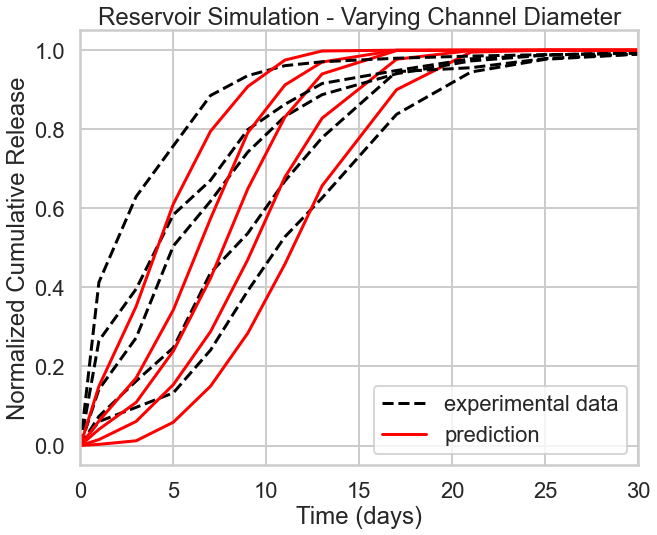

In [65]:
sb.set_style('whitegrid')
sb.set_context("poster")
rcParams['figure.figsize'] = 10,8

for i in range(len(diameter)):
    if i == 0:
        Data, Time_points = experimental_data(diameter[i])
        plt.plot(Time_points, Data, '--k',label='experimental data')
        Time_points, Cum_release, Data, P = Test_One_Diameter(n_ab, Size, diameter[i], s, L, ST, Diff, Bulk, Surf)
        plt.plot(Time_points,Cum_release, 'r',label='prediction')
    else:
        Data, Time_points = experimental_data(diameter[i])
        plt.plot(Time_points, Data, '--k')
        Time_points, Cum_release, Data, P = Test_One_Diameter(n_ab, Size, diameter[i], s, L, ST, Diff, Bulk, Surf)
        plt.plot(Time_points,Cum_release, 'r')
    
plt.xlabel('Time (days)')
plt.ylabel('Normalized Cumulative Release')
plt.xlim(left=0,right=30)
plt.title('Reservoir Simulation - Varying Channel Diameter')
plt.legend()